In [1]:
import os
import torch
import pandas as pd
from esm import pretrained, Alphabet, BatchConverter

In [2]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import esm

torch.set_grad_enabled(False)

In [3]:
esm2, esm2_alphabet = esm.pretrained.esm2_t6_8M_UR50D()
esm2 = esm2.eval().to("cuda")
esm2_batch_converter = esm2_alphabet.get_batch_converter()

In [4]:
input_fasta = "/home/ubuntu/uniref50.fasta"
output_csv = os.path.join(os.path.dirname(input_fasta), "uniprot50_perplexity.csv")

In [66]:
MAX_SEQUENCES = 10_000_000
MAX_LEN = 10000 # set by resources
DEVICE = "cuda"

In [5]:
def compute_masked_perplexity(seq: str, lambda_tokens: int = 1):
    data = [("protein", seq)]
    _, _, tokens = esm2_batch_converter(data)
    tokens = tokens.to(DEVICE)
    
    seq_len = tokens.size(1)
    valid_mask = (tokens != esm2_alphabet.padding_idx) & (tokens != esm2_alphabet.cls_idx) & (tokens != esm2_alphabet.eos_idx)
    valid_indices = torch.where(valid_mask[0])[0]

    if len(valid_indices) < lambda_tokens:
        return None  # too short

    # Sample λ random positions to mask
    masked_indices = np.random.choice(valid_indices.cpu().numpy(), size=lambda_tokens, replace=False)
    masked_tokens = tokens.clone()
    masked_tokens[0, masked_indices] = esm2_alphabet.mask_idx

    with torch.no_grad():
        logits = esm2(masked_tokens)["logits"]  # [1, seq_len, vocab_size]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # Gather true labels
    target_tokens = tokens[0, masked_indices]  # [λ]
    pred_log_probs = log_probs[0, masked_indices].gather(1, target_tokens.unsqueeze(1)).squeeze(1)  # [λ]

    # Compute perplexity
    masked_perplexity = torch.exp(-pred_log_probs.mean()).item()
    return masked_perplexity

In [6]:
def estimate_masked_perplexity(seq: str, lambda_t: int = 10, num_samples: int = 5):
    """
    Monte-Carlo Estimate of Masked Perplexity
    """
    lambda_tokens = max(1, len(seq) // lambda_t)
    data = [("protein", seq)]
    _, _, tokens = esm2_batch_converter(data)
    tokens = tokens.to(DEVICE)

    seq_len = tokens.size(1)
    valid_mask = (tokens != esm2_alphabet.padding_idx) & (tokens != esm2_alphabet.cls_idx) & (tokens != esm2_alphabet.eos_idx)
    valid_indices = torch.where(valid_mask[0])[0]

    if len(valid_indices) < lambda_tokens:
        return None

    log_prob_samples = []

    for _ in range(num_samples):
        sampled_indices = np.random.choice(valid_indices.cpu().numpy(), size=lambda_tokens, replace=False)
        masked_tokens = tokens.clone()
        masked_tokens[0, sampled_indices] = esm2_alphabet.mask_idx

        with torch.no_grad():
            logits = esm2(masked_tokens)["logits"]
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        target_tokens = tokens[0, sampled_indices]
        pred_log_probs = log_probs[0, sampled_indices].gather(1, target_tokens.unsqueeze(1)).squeeze(1)
        log_prob_samples.append(pred_log_probs.mean().item())

    avg_log_prob = np.mean(log_prob_samples)
    perplexity = np.exp(-avg_log_prob)
    return perplexity


In [ ]:
sequences = []
perplexities = []
ids = []


In [70]:
id_set = set(ids)

In [83]:
with open(input_fasta) as handle:
    for i, record in enumerate(SeqIO.parse(handle, "fasta")):
        if i >= MAX_SEQUENCES:
            break
        seq = str(record.seq)
        if "X" in seq:
            continue
        if len(seq) > MAX_LEN:
            continue
        if record.id in id_set:
            print("skipping")
            continue
        try:
            ppl = estimate_masked_perplexity(seq, lambda_t=20, num_samples=1000)
            sequences.append(seq)
            perplexities.append(ppl)
            ids.append(record.id)
            id_set.add(record.id)
            print(f"[{i}] {record.id}: Perplexity = {ppl:.2f}")
        except Exception as e:
            print(f"Error on sequence {record.id}: {e}")


skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
[2314] UniRef50_A0A6J2SWF6: Perplexity = 17.20
[2342] U

KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

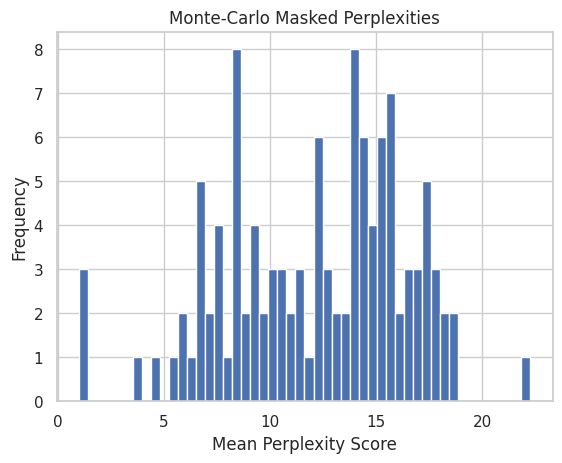

In [84]:
plt.hist(perplexities, bins=50)
plt.title("Monte-Carlo Masked Perplexities")
plt.xlabel("Mean Perplexity Score")
plt.ylabel("Frequency")


In [85]:
df = pd.DataFrame(
    {
    "sequence" : sequences,
    "perplexity" : perplexities,
    "unprot_id" : ids
    }
)

df.to_csv("biochemical_benchmarks/perplexity_sample_1.csv")
df.describe().to_csv("biochemical_benchmarks/perplexity_sample_1_simple_stats.csv")
df.describe()

,perplexity
count,114.000000
mean,12.176537
std,4.234370
min,1.011894
25%,8.645400
50%,12.841856
75%,15.417655
max,22.247514


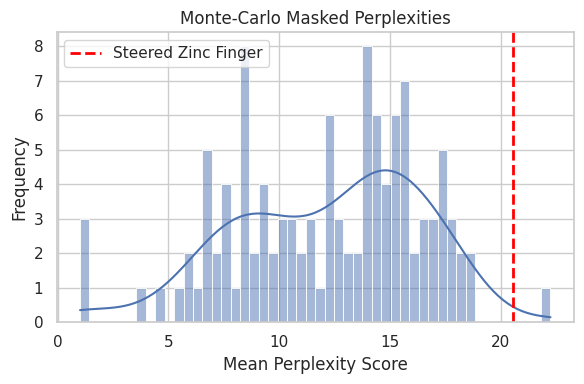

In [86]:
sample_seq = "MNYRCVKNGRKCEMIESHERKKTMVIVNYYTLQAALHMLIKATHISRVRIDKGGEAMGMQACYPNNTNTQGGPELMLSCKVAFNTAIMPQDKGPRYLLGWWPADKGDTSANRRRWGQDA"
new_sample_score = estimate_masked_perplexity(sample_seq, lambda_t=20, num_samples=100)

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.histplot(perplexities, bins=50, kde=True)
plt.axvline(new_sample_score, color='red', linestyle='--', linewidth=2, label='Steered Zinc Finger')
plt.title("Monte-Carlo Masked Perplexities")
plt.xlabel("Mean Perplexity Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
